BE/Bi 103, Fall 2014: Homework 7
================================
Due 1pm, Monday, December 8
---------------------------

*This document was generated from an IPython notebook.  You can download the notebook [here](hw7.ipynb).*

In [1]:
# As usual, import modules
from __future__ import division, absolute_import, print_function

import os
    
import numpy as np
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import scipy.ndimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

/Users/Justin/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Problem 7.1 (Caulobacter growth, 60 pts)

In this problem, we will study the growth and division of *Caulobacter crescentus* over time.  The lab of [Norbert Scherer](http://schererlab.uchicago.edu) at the University of Chicago acquired these data and recently published the work in PNAS, which you can download [here](http://bebi103.caltech.edu/2014/protected/papers/iyer-biswas_2014.pdf).

The clever experimental set-up allows imaging of single dividing cells in conditions that are identical through time.  This is accomplished by taking advantage of a unique morphological feature of *Caulobacter*.  The mother cell is adherent to the a surface through its stalk.  Upon division, one of the daughter cells does not have a stalk and is mobile.  The system is part of a microfluidic device that gives a constant flow.  So, every time a mother cell divides, the un-stalked daughter cell gets washed away.  In such a way, the dividing cells are never in a crowded environment and the buffer is always fresh.  This also allows for easier segmentation.

The data were sent to you via Dropbox.  They were kindly provided by Charlie Wright in the Scherer lab.  The frame rate is 1 frame per minute.  The interpixel spacing is 0.052 µm.  All images were acquired at 24 $^\circ$C.

As with any of the problems in this class, you are encouraged to explore the data beyond what is asked for specifically in the problems statements.  The paper is also a very interesting read.

**a)** The directory `sequential_full_field` contains 10 sequential frames of a full field of bacteria in the microfluidic device.  From these frames, choose which bacteria would be good to use to gather long time course imaging.  I.e., choose those that you think will give minimal errors in segmentation.  Give your reasoning, including images demonstrating segmentation.

**b)** The files `bacterium_1.tif` and `bacterium_2.tif` are TIFF stacks of time courses for specific cells in from the full field images.  From these time courses, compute the time scale of division of the cells.  In other words, compute the time between divisions for each division for each cell and plot the results.  Comment on any interesting aspects of these data.

**c)** In their paper, the authors argue that the growth rate of the cell is exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{\kappa t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0\kappa$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth rate.  Use the model selection methods we learned in class to assess the relative probabilites that the growth rate is exponential versus linear.

### Problem 7.1 solution

**a)** Before we load the images, we will write a function for performing segmentation.  We will user very simple segmentation techniques, since we have a large field of bacteria, so we can get good examples.  The strategy is simple: we perform Otsu thresholding and clear the borders.

In [2]:
def segment_image(im, buffer_size=9):
    """
    Return a binary image that is True where bacteria are
    """    
    return skimage.segmentation.clear_border(
                im < skimage.filters.threshold_otsu(im), buffer_size=buffer_size)

Now that we have this function, we'll load and segement the images, storing them in lists.

In [4]:
# Load images
img_dir = '../data/iyer-biswas_et_al/hw8_iyer-biswas_et_al/sequential_full_field/'
fnames = os.listdir(img_dir)
ims = [skimage.io.imread(os.path.join(img_dir, fname)) for fname in fnames]

# Threshold the images
im_bws = [segment_image(im) for im in ims]

We can now check the quality of the segmentaiton.  We first define an adaptation of the function `overlay_segmentation` that we used in homework 6.

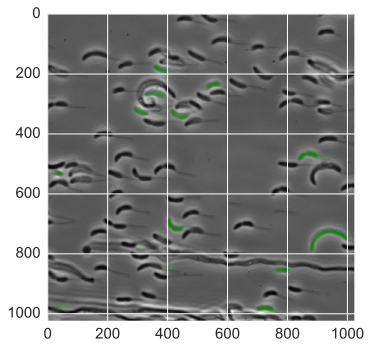

In [5]:
# Define function for showing overlay
def overlay_segmentation(ax, im, im_bw):
    """
    Overlay im_labeled of im.
    """
    # Convert phase image to float RGB
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Make the green channel 1/2 wherever we have a bacterium
    im_g = np.copy(im_float)
    im_g[im_bw] = 0.5

    # Build RGB image
    im_rgb = np.dstack((im_float, im_g, im_float))

    # Display image
    ax.imshow(im_rgb)
    
    return ax
    
# Display image and segmentation from first image
fig, ax = plt.subplots(1, 1)
ax = overlay_segmentation(ax, ims[0], im_bws[0])

Now, we'll display the first frame with the segmentation.

**b)**

In [61]:
data_dir = '../data/iyer-biswas_et_al/hw7_data_1'
fname = os.path.join(data_dir, 'bacterium_2.tif')
calo_xyt = jb.XYTStack(fname, dt=1.0, physical_size_x=0.052, 
                       physical_size_y=0.052)

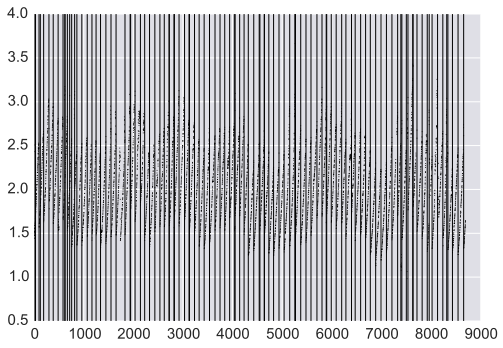

In [83]:
# Segment to get areas
areas = np.empty(calo_xyt.size_t)
for i in range(calo_xyt.size_t):
    im_bw = segment_image(calo_xyt.im(i))
    areas[i] = im_bw.sum()
areas *= calo_xyt.physical_size_x**2

# Filter out outliers
good_points = (areas[1:] < 5.0) & (areas[1:] > 1.0) & (np.diff(areas) < 0.1)
t = calo_xyt.t[good_points]
a = areas[good_points]

# Detect division events
div_events = np.nonzero(np.diff(a) < -0.4)[0]

plt.plot(t, a, 'k.', markersize=2)
for div in div_events:
    plt.axvline(t[div] - 0.5, lw=1)

(1000, 2000)

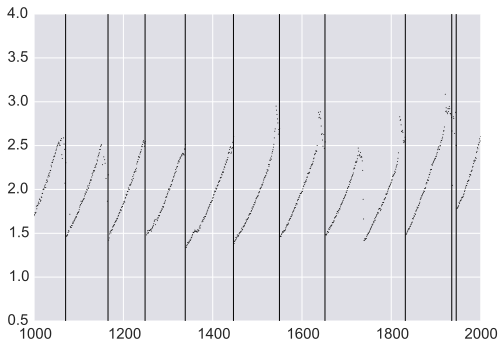

In [86]:
plt.plot(t, a, 'k.', markersize=2)
for div in div_events:
    plt.axvline(t[div] - 0.5, lw=1)
plt.xlim((1000, 2000))

plt.plot(calo_xyt.t, areas, 'k.', markersize=2)
plt.savefig('areas.pdf')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filter import threshold_otsu
from skimage.segmentation import clear_border
import jb_utils as jb
sns.set()

# Load XYT tiff stack
xyt = jb.XYTStack('bacterium.tif', dt=1.0, physical_size_x=0.052)

# Threshold and compute cell areas
areas = np.empty(xyt.size_t)
for i in range(xyt.size_t):
    im_bw = clear_border(xyt.im(i) < threshold_otsu(xyt.im(i)), buffer_size=9)
    areas[i] = im_bw.sum() * xyt.physical_size_x**2

# Detect outliers and division events
good_points = (areas[1:] < 5.0) & (areas[1:] > 1.0) & (np.diff(areas) < 0.1)
div_events = np.nonzero(np.diff(areas[1:][good_points]) < -0.6)[0]

# Plot results
fig = plt.figure(figsize=(10, 3))
plt.plot(xyt.t[good_points], areas[good_points], '.', color='#6A3D9A')
for i in range(len(div_events)):
    plt.axvline(xyt.t[good_points][div_events[i]] - 0.5, lw=1)
plt.xlabel('time (min)', fontsize=18)
plt.ylabel(u'cell area (µm)', fontsize=18)
plt.savefig('caulo_growth.pdf', bbox_inches='tight')

In [109]:
1 / 0.052

19.23076923076923

<br />
<br />

### Problem 7.2 (Colocalization of piRNA-related proteins, 40 pts)

Alex Webster from Alexei Aravin's lab discussed his study of colocalization of key proteins with Aubergine, a protein involved in the selective silencing of transposons in germ cells in the *Drosophila* egg chamber via piRNA pathways.  Among the three proteins he talked about are Krimper, Tudor, and Zucchini.  The former two are implicated in the ping-pong cycle that optimizes piRNA response.  It is thought that Zucchini is a nuclease that aids in constructing piRNA complexes.

In this problem, we will quantify the colocalization of these three proteins with Aubergine.  Aubergine is labeled with mKate2, a deep red fluorophore, and Krimper, Tudor, and Zucchini are labeled with GFP.  Alex has kindly provided us with three sets of images for each of the three constructs.  The data set can be downloaded [here](http://bebi103.caltech.edu/2014/protected/data/webster_et_al.zip).  The interpixel distance in these images is 0.162 µm.

Perform a colocalization analysis on these images and compare the colocalization between Aubergine and each the three proteins.

<br />
<br />

### Problem 7.3 (Your eyes are not as good as your computer, 5 pts extra credit)

Download the image below.  Use the basic image processing tools we learned in class to replace the beige and magenta colors with white and save the resulting image.  Display the original image and the altered image side by side.  (This problem was inspired by Dan White.)

[<img src="images/swirl.png">](http://bebi103.caltech.edu/2014/data/swirl.png)